In [1]:
library(devtools)
library(metacell)
load_all("../metacell.flow/")
scdb_init("output/scrna_db/",force_reinit = T)
scfigs_init("figs")
scdb_flow_init()

Loading required package: usethis

i Loading metacell.flow

initializing scdb to output/scrna_db/



In [2]:
mat_id = "oc_emb"
mc_id = "oc_emb"
feat_gset = "oc_emb"
mgraph_id = "oc_emb"

In [3]:
mat = scdb_mat(mat_id)
mc = scdb_mc(mc_id)
md = mat@cell_metadata
mgraph = scdb_mgraph(mgraph_id)

In [4]:
# md[is.na(md$embryo),]$embryo = 'empty'
md[md$embryo=='Rab5_e6_Anterior',]$embryo = "Rab5_e6"
md[md$embryo=='Rab5_e6_Posterior',]$embryo = "Rab5_e6"

md[md$embryo=='Rab8_e6_Anterior',]$embryo = "Rab8_e6"
md[md$embryo=='Rab8_e6_Posterior',]$embryo = "Rab8_e6"
md[md$embryo=='Rab8_e6_Trunk',]$embryo = "Rab8_e6"

md[md$embryo=='0824e4_anterior',]$embryo = "0824e4"
md[md$embryo=='0824e4_posterior',]$embryo = "0824e4"
md[md$embryo=='0824e4_middle',]$embryo = "0824e4"

md[md$embryo=='Rab15_e1_head',]$embryo = "Rab15_e1"
md[md$embryo=='Rab15_e1_midAnt',]$embryo = "Rab15_e1"
md[md$embryo=='Rab15_e1_midPost',]$embryo = "Rab15_e1"
md[md$embryo=='Rab15_e1_tail',]$embryo = "Rab15_e1"

In [5]:
# groups = read.table("embs_grouping.txt", sep="\t", header = T)
groups = read.table("oc_embs_grouping.txt", sep="\t", header = T)
mc_col = mc@colors
names(mc_col) = mc@annots
cell_mc_cols <- tibble::enframe(mc@mc) %>% rename(cell=name, mc_id=value) %>% left_join(
    tibble::enframe(mc_col) %>% rename(mc_id=name, color=value) %>% mutate(mc_id = as.numeric(mc_id)), on=mc_id)
cell_mc_cols$cell_short <- (
    data.frame(do.call('rbind', strsplit(as.character(cell_mc_cols$cell),'.',fixed=TRUE))) %>% rename(plate=X1, cell=X2)
)$cell
md$Well_ID <- (data.frame(do.call('rbind', strsplit(as.character(rownames(mat@cell_metadata)),'.',fixed=TRUE))) %>% rename(plate=X1, cell=X2))$cell

Joining, by = "mc_id"


In [6]:
cell_emb_groups = md %>% left_join(groups, by = 'embryo') %>% rename(cell_short=Well_ID)
rownames(cell_emb_groups) = rownames(md)
cells_md <- cell_mc_cols %>% left_join(cell_emb_groups, by="cell_short") %>% rename(group=chunk.y)
time_age_groups = unique(groups$gt)
names(time_age_groups) = names(table(cells_md$group))
groups_times = tibble::enframe(time_age_groups) %>% rename(group=name, gt=value)
cells_md$group = as.character(cells_md$group)
cells_md = cells_md %>% left_join(groups_times, by="group")
cells_md = as.data.frame(cells_md)
rownames(cells_md) = cells_md$cell.x
cell_time = cells_md[names(mc@mc),"gt.y"]
names(cell_time) = names(mc@mc)
new_df = table(cells_md[names(mc@mc), "gt.y"], mc@mc)
new_df = cbind(rep("gt", nrow(new_df)), new_df)
setdiff(colnames(mat@cell_metadata), colnames(cells_md))

[1] "cell"  "chunk"

In [7]:
oc_color_ord = c( 
'#FACB12', #PGC
'#f7f79e', #Surface ectoderm
'#CDE087', #Floor plate
'#C3C388', #Neural crest
'#879E86', #Neural plate boundary
'#CDE088', #Neural tube
'#647A4F', #Forebrain/Midbrain/Hindbrain
'#354E23', #Caudal neurectoderm
'#649146', #rostral neurectoderm
'#90BF75', #Ectoderm - Definitive
'#635547', #epiblast
'#DABE99', #Primitive streak
'#9e6762', #caudal epiblast
'#E2F700', #Median TFAP
'#C594BF', #nascent mesoderm
'#1a3f52', #caudal mesoderm
'#45d1c5', #Lateral & intermediate mesoderm
'#408DA1', #Paraxial Mesoderm
'#A8DBF7', #Presomitic mesoderm
'#1AA2EB', #Somitic mesoderm
'#8DB5CE', #rostral mesoderm
'#53f1fc', #Cardiopharyngeal mesoderm
'#B51D8D', #Caridac
'#B6A8ED', #Nascent mesoderm - extraembryonic
'#8870ad', #ExE mesoderm
'#cc7818', #Amnion
'#532C8A', #Allantois
'#A69369', #chorionic mesothelium
'#966F1B', #Endothelial2
'#ff891c', #Endothelial
'#FBBE92', #Hematoendothelial
'#c9a997', #Blood progenitors
'#C72228', #Erythroid1
'#FF5608', #Erythroid2
'#c19f70', #Anterior primitive streak
'#6666ED', #Node
'#0F4A9C', #notochord
'#F397C0', #definitive endoderm
'#EF5A9E', #Gut
'#EF5A9D', #Foregut
'#F25CD4' #Hindgut
)

[1] 2569

[1] 2569

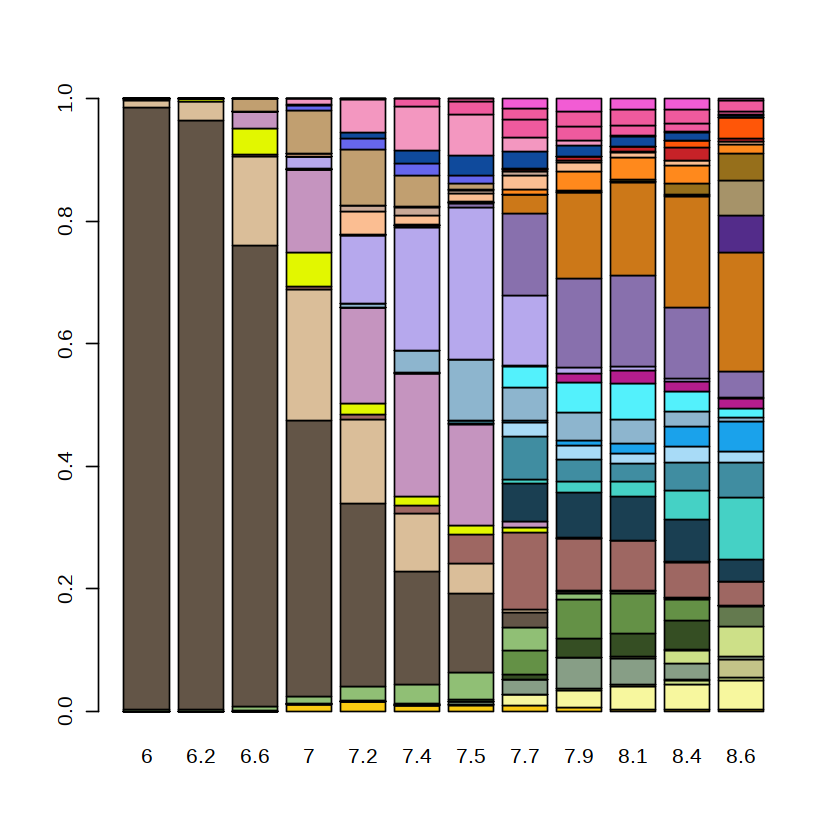

In [8]:
cell_time_f = cell_time[!is.na(cell_time)]

max(mc@mc)
mc_t = table(mc@mc,cell_time_f[names(mc@mc)])
mc_t = t(t(mc_t)/colSums(mc_t))
nrow(mc_t)

ct_ag_init = tgs_matrix_tapply(as.matrix(as.data.frame.matrix(t(mc_t))),mc@colors,sum)
ct_ag_init = ct_ag_init[oc_color_ord,]
barplot(ct_ag_init,col = rownames(ct_ag_init))

In [68]:
prof = read.table('prolif_test1.tsv', header = T)

In [69]:
prof$color = mc@colors[prof$mc]

In [70]:
mcts = cells_md %>% group_by(mc_id)  %>% summarise(mct = mean(gt.x, na.rm = T))

In [71]:
prof = prof %>% left_join(mcts %>% rename(mc = mc_id), by='mc')

In [72]:
net_id = "oc_embflow_test10"

In [73]:
cap_var_factor = rep(0.25,ncol(mc@e_gc))

In [30]:
oc_emb_hc = scdb_mgraph("oc_emb_hc")

In [28]:
oc_emb_hc@mc_id = 'oc_emb'

In [29]:
scdb_add_mgraph("oc_emb_hc", oc_emb_hc)

In [25]:
oc_emb = scdb_mgraph("oc_emb")

In [27]:
oc_emb@mc_id

[1] "oc_emb"

In [74]:
# generating the network
mcell_mctnet_from_mgraph(
    net_id = net_id,
    capacity_var_factor = cap_var_factor,
    mgraph_id = mgraph_id,
    cell_time = cell_time[!is.na(cell_time)],
    mc_proliferation_rate_fn = "prolif_test1.tsv",
    time_age_groups = time_age_groups,
    off_capacity_cost1 = 1,
    off_capacity_cost2 = 5000
)

In [75]:
flow_id = "oc_embflow_test10"
fig_dir = "figs/"
net_id = "oc_embflow_test10"

flow_tolerance = 0.02

message("generate flows")

mcell_new_mctnetflow(flow_id, net_id, 
                     init_mincost = T, flow_tolerance= flow_tolerance)

message("solved network flow problem")

mcf = scdb_mctnetflow(flow_id)

generate flows

solved network flow problem



In [76]:
#compute propagatation forward and background
mcf = mctnetflow_comp_propagation(mcf)

#adding back the object with the network and flows
scdb_add_mctnetflow(flow_id, mcf)

In [77]:
mm_mctnetwork_plot_net(mct_id = "oc_embflow_test10", flow_id = "oc_embflow_test10",fn = "figs/oc_embflow_new10.png",
    show_over_under_flow = T,
#     show_axes=F,
#     mc_ord = rank(names(mc_rank[order(mc_rank)])),
    colors_ordered = oc_color_ord,
    plot_mc_ids = F,
#     plot_pdf = T,
#     w = 10,
#     h = 10
    h = 2000,
    w = 5000
)

png 
  2

In [14]:
mm_mctnetwork_plot_net(mct_id = "oc_embflow", flow_id = "oc_embflow",fn = "figs/oc_embflow_old_without_over_under_flow.png.pdf",
    show_over_under_flow = F,
#     show_axes=F,
#     mc_ord = rank(names(mc_rank[order(mc_rank)])),
    colors_ordered = oc_color_ord,
    plot_mc_ids = F,
    plot_pdf = T,
    w = 10,
    h = 10
#     h = 2000,
#     w = 5000
)

png 
  2

In [15]:
mm_mctnetwork_plot_net(mct_id = "oc_embflow_test", flow_id = "oc_embflow_test",fn = "figs/oc_embflow_new_without_over_under_flow.png",
    show_over_under_flow = F,
#     show_axes=F,
#     mc_ord = rank(names(mc_rank[order(mc_rank)])),
    colors_ordered = oc_color_ord,
    plot_mc_ids = F,
#     plot_pdf = T,
#     w = 10,
#     h = 10
    h = 2000,
    w = 5000
)
mm_mctnetwork_plot_net(mct_id = "oc_embflow_test", flow_id = "oc_embflow_test",fn = "figs/oc_embflow_new_without_over_under_flow.png.pdf",
    show_over_under_flow = F,
#     show_axes=F,
#     mc_ord = rank(names(mc_rank[order(mc_rank)])),
    colors_ordered = oc_color_ord,
    plot_mc_ids = F,
    plot_pdf = T,
    w = 10,
    h = 10
#     h = 2000,
#     w = 5000
)

png 
  2

png 
  2

In [21]:
net_id = "oc_embflow"
mct = scdb_mctnetwork(net_id)
mcf = scdb_mctnetflow(net_id)

In [25]:
ct_ag_inf = tgs_matrix_tapply(t(mcf@mc_t_infer),mc@colors,sum)
ct_ag_inf = ct_ag_inf[oc_color_ord,]

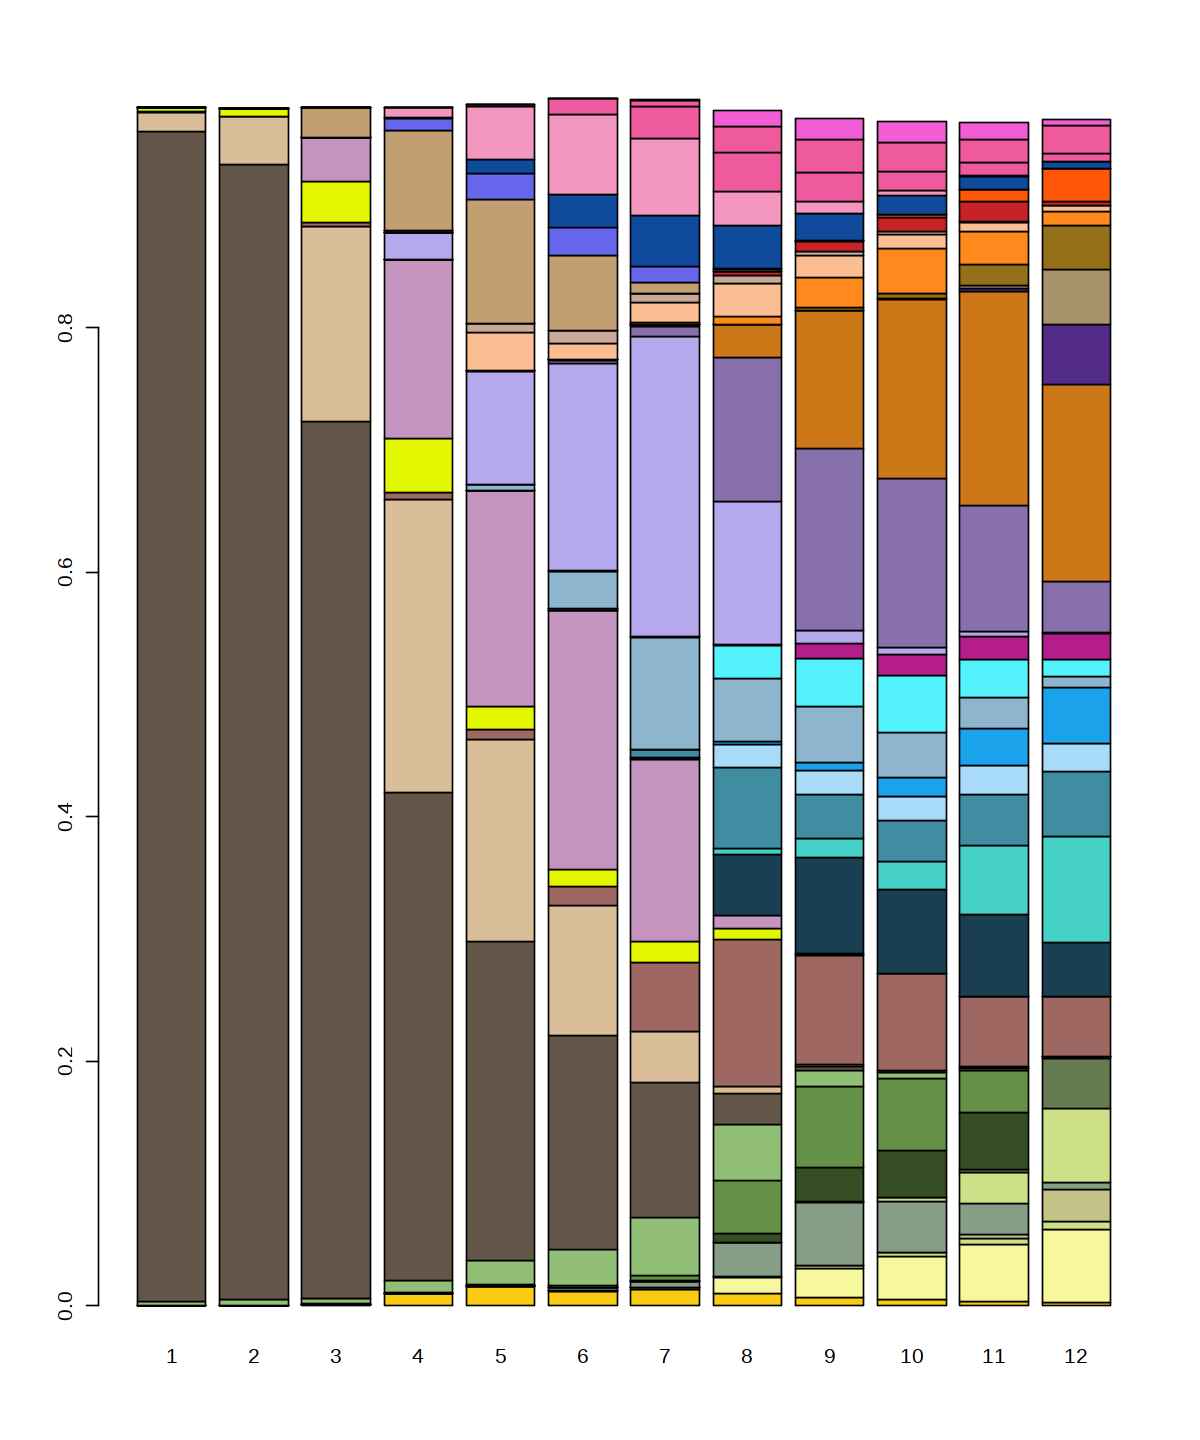

In [26]:
barplot(ct_ag_inf,col = rownames(ct_ag_inf))

In [27]:
ym = c("HAND1", "COL3A1", "CER1", "LMO2", "VCAN", "ACTC1", "NKX1-2", "RSPO3", "CRABP2", "COL3A1", "LHX1", "DNMT3B", "FLI1", "CDH5", "NANOGP8_hg19", "ALAS2", "ALAS2", "HAND1", "PTCH1", "DPYSL3", "SLC16A1", "SLC16A1", "ETV2", "SLC7A8", "GPC3", "MKRN1", "T", "PLAGL1", "TFAP2B", "DLX5", "CHRD", "NOTO", "FOXC1", "TFAP2C", "RIPPLY1", "POU5F1", "SHISA2", "OTX2", "ALDH1A2", "PLET1", "COL3A1", "ANXA2", "LHX1", "GATA1", "SFRP5", "MYL4", "CDX1", "MSGN1", "CRABP1", "DLK1", "SLC16A1", "POU5F1", "LMO2", "RAMP2", "UTF1", "GATA1", "GLRX", "FOXF1", "NKX2-8", "OTX2", "FOXA1", "TF", "LMO2", "SLC3A2", "OSR1", "TFAP2A", "PLAGL1", "HAND1", "SOX10", "EFNA5", "FOXA2", "DNAJB13", "TCF15", "PASD1", "DNMT3B", "CER1", "SOX2", "MEOX1", "WNT6", "HAND2", "DLK1", "FOXA2", "TNNI1", "GRSF1", "TBX6", "SOX3", "ITGA4", "FOXA2", "TEK", "CD93", "GLRX", "SLC25A37", "MSX2", "SALL2", "FOXA2", "SRGN", "TAL1", "APOA2", "TFAP2C", "MIXL1", "MSX1", "SHISA2", "PRDM1", "EOMES", "HESX1", "TNNT2", "DLL1", "NES", "CER1", "ETV2", "NFE2", "HMBS", "SOX2", "AP1S3", "SLC7A8", "EFNA5", "EOMES", "TDGF1", "T", "GRSF1", "SOX2", "SOX17", "GYPA", "APOE", "SLC3A2", "SOX17", "APOE", "APLP2", "AP1S3", "TDGF1", "CDX2", "SOX17", "SHISA2", "HHEX", "CER1", "TBX6", "WNT3A", "RSPO3")
ym = unique(ym)
length(ym)

[1] 96

In [28]:
rabbit_legc = log2(1e-5+mc@e_gc)
markers_rabbit_legc_n = rabbit_legc[ym,] - rowMeans(rabbit_legc[ym,])

In [29]:
clust_order = c(
'PASD1',
'TFAP2C',
'WNT6',
# 'TFAP2B',
'SOX10',
'DLX5',
'TFAP2A',
# 'HESX1',
#     'SHISA2',
    'OTX2',
'SOX2',
# 'DPYSL3',
# 'EFNA5',
'POU5F1',
'NANOGP8_hg19',
    'TDGF1',
'EOMES',
    'MIXL1',
    'T',
'MSGN1',
'CDX1',
'NKX1-2',
'CDX2',
'RSPO3',
'OSR1',
'FOXC1',
# 'DLL1',
'TCF15',
'RIPPLY1',
'MEOX1',
'SFRP5',
# 'ACTC1',
'TNNI1',
'FOXF1',
'HAND1',
# 'ANXA2',
'DLK1',
'ITGA4',
'CDH5',
'CD93',
'LMO2',
'TAL1',
'ETV2',
'GATA1',
'GYPA',
'NOTO',
    # 'HMBS',
'LHX1',
# 'CHRD',
'FOXA2',
# 'DNAJB13',
'SOX17',
'APOE',
# 'APOA2',
'FOXA1'
)

In [30]:
mc_mean_age = apply(mct@mc_t, 1, function(x) {return(mean(x*(1:length(x))/sum(x))) })
col_to_rank = c(1:length(oc_color_ord))
names(col_to_rank) = oc_color_ord

mc_rank = 1000*col_to_rank[mc@colors] + mc_mean_age
mc_ord = order(mc_rank)

In [31]:
oc_col2cat = mc@color_key$cell_type
names(oc_col2cat) = mc@color_key$color

oc_cat2col = mc@color_key$color
names(oc_cat2col) = mc@color_key$cell_type

oc_mc_cats = unname(oc_col2cat[mc@colors])
names(oc_mc_cats) = names(mc@colors)

In [32]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

png 
  2

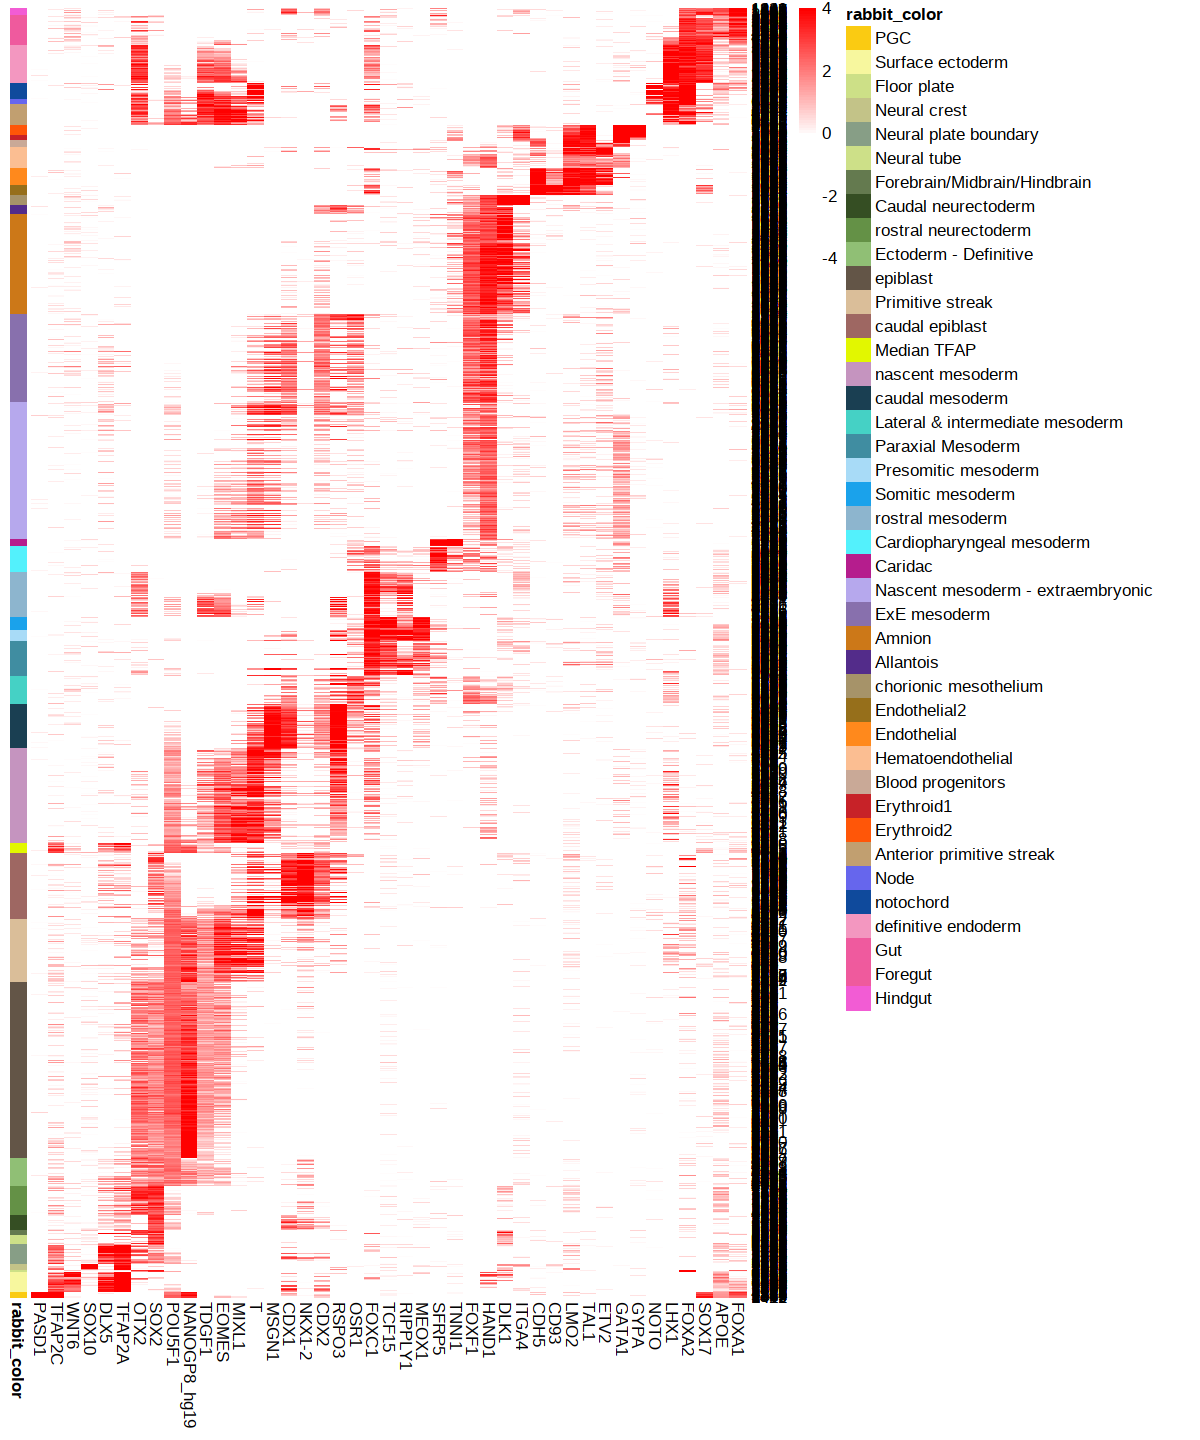

In [48]:
options(repr.plot.width=10, repr.plot.height=12)
test = markers_rabbit_legc_n
paletteLength <- 100
myColor <- colorRampPalette(c("white", "white", "red"))(paletteLength)
# length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
# myBreaks <- c(seq(min(test), 0, length.out=ceiling(paletteLength/2) + 1), 
#               seq(max(test)/paletteLength, max(test), length.out=floor(paletteLength/2)))
myBreaks <- c(seq(-4, 0.5, length.out=ceiling(paletteLength/2) + 1), 
              seq(3/paletteLength, 4, length.out=floor(paletteLength/2)))
ph = pheatmap::pheatmap(
    t(markers_rabbit_legc_n[clust_order,rev(mc_ord)]), 
    cluster_cols = F, 
    color = myColor, 
    breaks = myBreaks,
    cluster_rows = F, 
    annotation_row = data.frame(rabbit_color=oc_mc_cats),
    annotation_colors = list(rabbit_color=oc_cat2col),)
save_pheatmap_pdf(ph, "flow_heatmap.pdf", 10,12)